In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [2]:
!gdown 1eMkx2XajffzCP-lyBAuaBU8x8d7mK1-A

Downloading...
From: https://drive.google.com/uc?id=1eMkx2XajffzCP-lyBAuaBU8x8d7mK1-A
To: /content/Mall_Customers (1).csv
100% 3.98k/3.98k [00:00<00:00, 17.3MB/s]


In [3]:
data=pd.read_csv("Mall_Customers (1).csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [5]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


<Axes: xlabel='Spending Score (1-100)', ylabel='Count'>

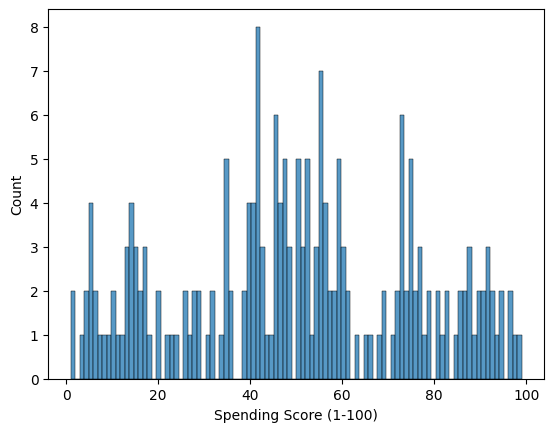

In [6]:
import seaborn as sns
sns.histplot(x="Spending Score (1-100)", data=data, bins=100)

In [7]:
# Null checking
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
from sklearn.cluster import KMeans
import pandas as pd

# Tạo một DataFrame mới chỉ chứa hai cột cần phân cụm
X = data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Khởi tạo mô hình KMeans với 5 cụm
kmeans = KMeans(n_clusters=5)

# Huấn luyện mô hình trên dữ liệu
kmeans.fit(X)

# Thêm một cột mới vào DataFrame data để lưu nhãn của các cụm
data['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
label_encoders = {} #
# Fit and transform each categorical variable
label_encoders["Gender"] = LabelEncoder()
data["Gender"] = label_encoders["Gender"].fit_transform(data["Gender"])

In [10]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,1,19,15,39,1
1,2,1,21,15,81,3
2,3,0,20,16,6,1
3,4,0,23,16,77,3
4,5,0,31,17,40,1
...,...,...,...,...,...,...
195,196,0,35,120,79,0
196,197,0,45,126,28,4
197,198,1,32,126,74,0
198,199,1,32,137,18,4


In [11]:
# Split X, y from dataset
columns = data.columns.tolist()     # Columns name
columns.remove('Cluster')           # Remove y label (column charges in this case)
X = data[columns]                            # X
y = data.loc[:, "Cluster"]    # y
# INPUT -> DEEP->CỤM SỐ MẤY

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
#
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_rate = dropout_rate

        self.layers = nn.ModuleList()
        for i in range(len(hidden_sizes)):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_sizes = [128, 64, 32]
output_size = len(torch.unique(y_train_tensor))  # Number of unique classes
dropout_rate = 0.2
model = NeuralNetwork(input_size, hidden_sizes, output_size, dropout_rate)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Convert the data into PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.tolist())
            val_targets.extend(labels.tolist())
    val_loss /= len(val_loader)

    precision = precision_score(val_targets, val_preds, average='macro')
    recall = recall_score(val_targets, val_preds, average='macro')
    f1 = f1_score(val_targets, val_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 1/50, Train Loss: 1.6413, Val Loss: 1.6216, Precision: 0.0133, Recall: 0.2000, F1-score: 0.0250
Epoch 2/50, Train Loss: 1.5939, Val Loss: 1.5944, Precision: 0.2148, Recall: 0.2667, F1-score: 0.1276
Epoch 3/50, Train Loss: 1.5678, Val Loss: 1.5641, Precision: 0.5524, Recall: 0.4433, F1-score: 0.3410
Epoch 4/50, Train Loss: 1.5198, Val Loss: 1.5280, Precision: 0.5202, Recall: 0.5333, F1-score: 0.4370
Epoch 5/50, Train Loss: 1.5140, Val Loss: 1.4841, Precision: 0.5824, Recall: 0.6833, F1-score: 0.5878
Epoch 6/50, Train Loss: 1.4409, Val Loss: 1.4326, Precision: 0.4723, Recall: 0.5133, F1-score: 0.4913
Epoch 7/50, Train Loss: 1.3867, Val Loss: 1.3713, Precision: 0.5364, Recall: 0.5333, F1-score: 0.5222
Epoch 8/50, Train Loss: 1.3707, Val Loss: 1.3063, Precision: 0.5364, Recall: 0.5333, F1-score: 0.5222
Epoch 9/50, Train Loss: 1.2619, Val Loss: 1.2410, Precision: 0.5429, Recall: 0.5667, F1-score: 0.5485
Epoch 10/50, Train Loss: 1.1950, Val Loss: 1.1718, Precision: 0.5429, Recall: 0.56

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/50, Train Loss: 0.5775, Val Loss: 0.5785, Precision: 0.6433, Recall: 0.7600, F1-score: 0.6914
Epoch 21/50, Train Loss: 0.5894, Val Loss: 0.5333, Precision: 0.6433, Recall: 0.7600, F1-score: 0.6914
Epoch 22/50, Train Loss: 0.5814, Val Loss: 0.4892, Precision: 0.6433, Recall: 0.7600, F1-score: 0.6914
Epoch 23/50, Train Loss: 0.6003, Val Loss: 0.4556, Precision: 0.8679, Recall: 0.8933, F1-score: 0.8629
Epoch 24/50, Train Loss: 0.4915, Val Loss: 0.4236, Precision: 0.8833, Recall: 0.9600, F1-score: 0.9092
Epoch 25/50, Train Loss: 0.4330, Val Loss: 0.3942, Precision: 0.8833, Recall: 0.9600, F1-score: 0.9092
Epoch 26/50, Train Loss: 0.3736, Val Loss: 0.3704, Precision: 0.8608, Recall: 0.9267, F1-score: 0.8853
Epoch 27/50, Train Loss: 0.3713, Val Loss: 0.3479, Precision: 0.8608, Recall: 0.9267, F1-score: 0.8853
Epoch 28/50, Train Loss: 0.3688, Val Loss: 0.3229, Precision: 0.8857, Recall: 0.9400, F1-score: 0.9060
Epoch 29/50, Train Loss: 0.3923, Val Loss: 0.3028, Precision: 0.8857, Rec